Student name: Nicholas Murphy

Student ID: 21268819

## Task 1
Download the files

In [137]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn import neighbors
from sklearn.decomposition import FastICA
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE

In [138]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

## Task 2
* Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the * results you observe in a markdown cell. - ✅ 
* Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown * cell (max 250 words in a markdown cell). - ✅



### EDA

#### What categories has region got?

In [139]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

#### Check for null values

In [140]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

#### Check for basic statisics

In [141]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

Unlike the tutorial and its 0 Weight value, here we have a zero minimum for children, which *is* a valid value. So I don't think this warrants further scrutiny.

### Check for outliers
I'm dropping insurance_cost from the boxplot as this is the dependent variable and has a bunch of outliers if included.

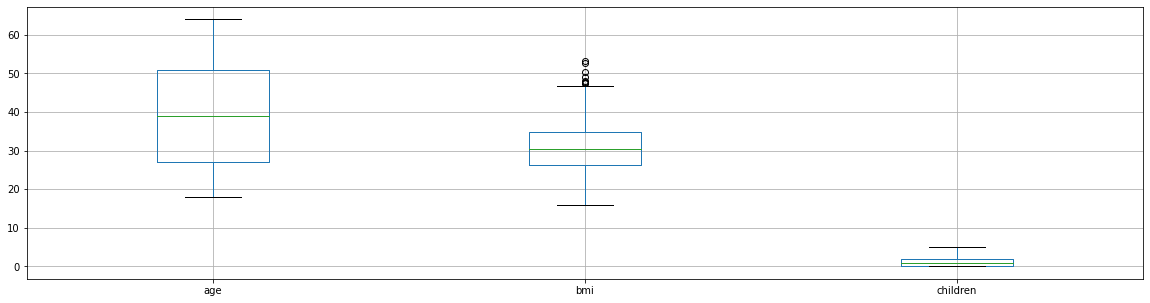

In [142]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

Looks like bmi has some outliers, but if we're going by the tutorial, they don't seem sufficiently extreme to warrent scaling. I could be wrong on this.

Next, we will replace the categorical column `region` by multiple numerical columns. Since the names of the species do not have order, we will use `one-hot encoding` to do this. 

In [143]:
df = pd.get_dummies(df, columns=['region'], 
                        #dummy_na=True, 
                        drop_first=True)

map the yes/no values in smoker to 1/0

In [144]:
yesnomapper = {'yes':1,'no':0}
df['smoker'] = df['smoker'].replace(yesnomapper)
df['smoker'].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

use one_hot to map genders, dropping the first value

In [145]:
df = pd.get_dummies(df,drop_first=True)

In [146]:
df.head()

age     bmi  children  smoker  insurance_cost  region_northwest  \
0   18  33.770         1       0      1725.55230                 0   
1   18  34.100         0       0      1137.01100                 0   
2   18  26.315         0       0      2198.18985                 0   
3   18  38.665         2       0      3393.35635                 0   
4   18  35.625         0       0      2211.13075                 0   

   region_southeast  region_southwest  gender_male  
0                 1                 0            1  
1                 1                 0            1  
2                 0                 0            0  
3                 0                 0            0  
4                 0                 0            0

Since there are no obvious outliers, we will apply `StandardScaler` to all predictor columns witha very simple (compared to example A) pre-rpocessing pipeline.

In [147]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [148]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline
The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [149]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [150]:
N_FEATURES_OPTIONS = [2,4,6]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

### Linear Regression Pipeline

In [151]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In the below code, I'm removing the normalize options from SVR as these are being deprecated ("The default behavior of this estimator is to not do any normalization")

In [152]:
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_


Best CV score = 0.740:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


### KNN Regression

In [153]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', neighbors.KNeighborsRegressor())])

In [154]:
# create the pipeline
 
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
        'regression__weights' :['uniform','distance'],
        'regression__algorithm' :['auto','ball_tree','kd_tree','brute'],

    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
        'regression__weights' :['uniform','distance'],
        'regression__algorithm' :['auto','ball_tree','kd_tree','brute'],

    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.824:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regression__algorithm': 'brute', 'regression__n_neighbors': 9, 'regression__weights': 'uniform'}


## Compare Regression Models on Test Set
Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [155]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute prediction for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [156]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)

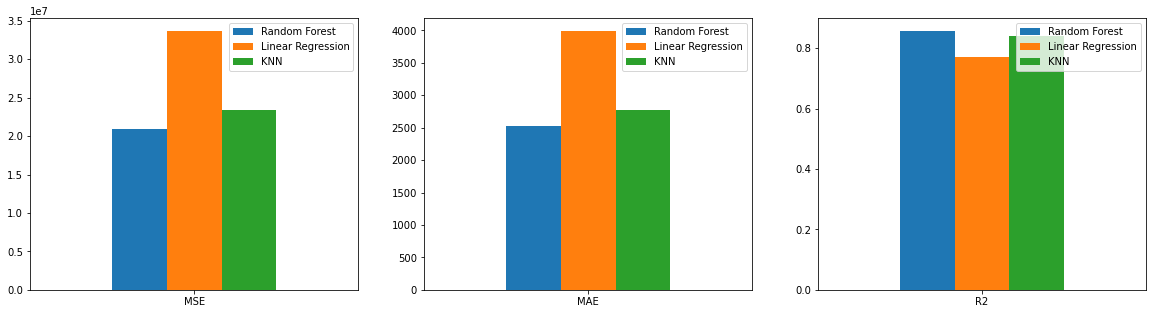

In [157]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNN': KNN_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNN': KNN_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNN': KNN_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## Task 2 conclusion
In this task I've worked the insurance dataset through the lab code, performing some EDA - converting categorical values to ordinal using mappers and one_hot encoding. After checking for outliers, I've used three Pipelines to scale, feature reduce and Random Forest, Linear regressions and K Nearest Neighbour. 

Like in the tutorial, Random Forest is shown to be a better regression model as both Mean Square and Mean Absolute Errors are lower than in the linear regression and KNN. RFs R2 (CV) LRs and KNNs 

## Train a Final Model
Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [158]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

## Task 3

* Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv.  - ✅ Added ICA and FactorAnalysis. Tried TSNE but couldn't make it work.
* Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell). - ✅



### Random forest with ICA and FactorAnalysis 

In [159]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])
N_FEATURES_OPTIONS = [2,4,6]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
N_ITER = [100,200,300]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__random_state': [12],
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.858:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__max_depth': 4}


### Linear Regression with ICA and FactorAnalysis

In [160]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])
N_FEATURES_OPTIONS = [2,4,6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__random_state': [12]
    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_


Best CV score = 0.740:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


### KNearestNeighbour with ICA and FactorAnalysis

In [161]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', neighbors.KNeighborsRegressor())])
# create the pipeline

 
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__random_state': [12],
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
        'regression__weights' :['uniform','distance'],
        'regression__algorithm' :['auto','ball_tree','kd_tree','brute'],

    },
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_neighbors' :[3,4,5,6,7,8,9],
        'regression__weights' :['uniform','distance'],
        'regression__algorithm' :['auto','ball_tree','kd_tree','brute'],


    }   
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.824:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regression__n_neighbors': 9}


In [162]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)

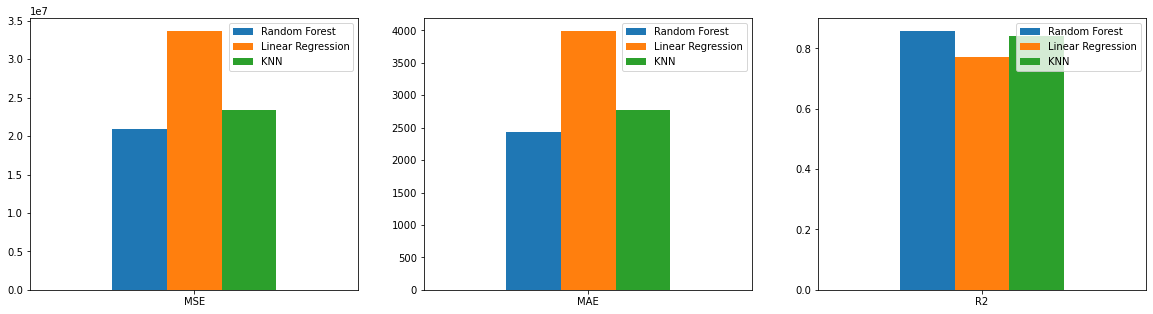

In [163]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNN': KNN_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNN': KNN_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNN': KNN_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Task 3 Conclusion
In this task I added two new reducers - FastICA for Independent Component Analysis and FactorAnalysis for factor analysis. I was also going to add TSNE but ran into problems due to it not implementing tranform().

Overall, there is no difference in results be adding these two reducers in. My assumption is that they make no discernable difference to the pipeline and that the existing reducers are giving better results.